# Notebook for the Assignment 1

The utility functions are copied from [Stanford cs231n course](https://github.com/cs231n/cs231n.github.io). You can download the preliminary code for this assignment from [this link](http://cs231n.github.io/assignments/2018/spring1718_assignment1.zip).

Data loading:

In [1]:
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [2]:
import random
import numpy as np
#from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

To download the data I have used the script from cs213n again:

```
cd cs231n/datasets
./get_datasets.sh
```

In this next block I have used the cs231n script nearly exactly. The only change is that, on top of of making the dataset 0-mean the input dataset is also normalized to the 0-1 range.

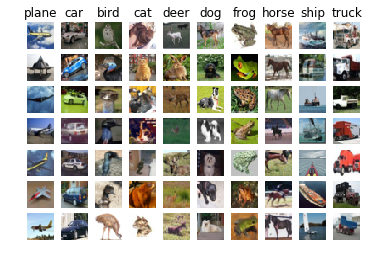

Train data shape:  (45000, 3073)
Train labels shape:  (45000,)
Validation data shape:  (5000, 3073)
Validation labels shape:  (5000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [3]:
def get_CIFAR10_data(num_training=45000, num_validation=5000, num_test=1000, num_dev=500, uniform_std=False):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Visualize some examples from the dataset.
    # We show a few examples of training images from each class.
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 7
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # and just normalize to 0-1 range, without making the dataset 0-mean
    max_image = 255
    X_train /= max_image
    X_val /= max_image
    X_test /= max_image
    X_dev /= max_image
    
    if uniform_std:
        std_image = np.std(X_train, axis = 0)
        X_train /= std_image
        X_val /= std_image
        X_test /= std_image
        X_dev /= std_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

The skeleton of the code for the next block is copied from the cs231n course. Here I have implemented the vectorized and non-vectorized softmax loss and gradient.

In [4]:
import numpy as np
from random import shuffle
#from past.builtins import xrange

def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    numberOfSamples = X.shape[0]
    numberOfClasses = W.shape[1]
    
    for i in range(numberOfSamples):
        s = X[i].dot(W)
        s -= s.max()
        expS = np.exp(s)
        sumOfExpS = np.sum(expS)
        p = expS / sumOfExpS
        loss += -np.log(p[y[i]])
        
        for c in range(numberOfClasses):
            dW[:,c] += (p-(y[i]==c))[c]*X[i]
    
    loss /= numberOfSamples
    loss += reg*np.sum(W**2)
    dW /= numberOfSamples
    dW += 2*reg*W
    
    #pass
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW


def softmax_loss_vectorized(W, X, y, reg, X_val = None, y_val = None):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    
    numberOfSamples = X.shape[0]
    
    s = X.dot(W)
    s -= s.max(axis=1, keepdims=True)
    expS = np.exp(s)
    sumOfExpS = np.sum(expS, axis=1, keepdims=True)
    p = expS / sumOfExpS
    p_y = p[range(numberOfSamples), y]
    #divide by zero check
    p_y[p_y==0] = np.nextafter(0, 1)
    loss = np.sum(-np.log(p_y))
    loss /= numberOfSamples
    
    dS = p
    dS[range(numberOfSamples), y] -= 1
    dS /= numberOfSamples
    dW = X.T.dot(dS)
    
    dW += 2*reg*W
    loss += reg*np.sum(W**2)
    
    
    
    #pass
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW



In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

#from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('calculated loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

calculated loss: 2.303606
sanity check: 2.302585


This sanity check looks ok because:

> Uniform random (with low variance) weights => predictions should be uniform => p~0.1 for each class

In this next block I have added the provided numerical gradient checking. Then I compared this with my own implementation.

In [6]:
# this is gradient_check.py file provided by stanford
from __future__ import print_function
#from past.builtins import xrange

import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
  """
  Compute numeric gradients for a function that operates on input
  and output blobs.
  
  We assume that f accepts several input blobs as arguments, followed by a blob
  into which outputs will be written. For example, f might be called like this:

  f(x, w, out)
  
  where x and w are input Blobs, and the result of f will be written to out.

  Inputs: 
  - f: function
  - inputs: tuple of input blobs
  - output: output blob
  - h: step size
  """
  numeric_diffs = []
  for input_blob in inputs:
    diff = np.zeros_like(input_blob.diffs)
    it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      orig = input_blob.vals[idx]

      input_blob.vals[idx] = orig + h
      f(*(inputs + (output,)))
      pos = np.copy(output.vals)
      input_blob.vals[idx] = orig - h
      f(*(inputs + (output,)))
      neg = np.copy(output.vals)
      input_blob.vals[idx] = orig
      
      diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

      it.iternext()
    numeric_diffs.append(diff)
  return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
  return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))



In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
#from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.000881 analytic: 0.000881, relative error: 3.157595e-08
numerical: 0.002859 analytic: 0.002859, relative error: 1.355039e-08
numerical: -0.022150 analytic: -0.022150, relative error: 2.540164e-09
numerical: -0.001118 analytic: -0.001118, relative error: 1.877987e-08
numerical: -0.016250 analytic: -0.016250, relative error: 9.883249e-11
numerical: 0.001259 analytic: 0.001259, relative error: 9.468764e-09
numerical: 0.004540 analytic: 0.004540, relative error: 2.704556e-10
numerical: 0.001263 analytic: 0.001263, relative error: 6.068508e-09
numerical: 0.006452 analytic: 0.006452, relative error: 7.292346e-09
numerical: 0.009668 analytic: 0.009668, relative error: 1.318712e-09
numerical: 0.101177 analytic: 0.101177, relative error: 9.614952e-10
numerical: -0.224490 analytic: -0.224490, relative error: 2.242548e-10
numerical: 0.088744 analytic: 0.088744, relative error: 3.784447e-10
numerical: -0.072740 analytic: -0.072740, relative error: 9.075217e-10
numerical: 0.000729 anal

And now I compare my non-vectorized implementation with the vectorized one.

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.303606e+00 computed in 0.205889s
vectorized loss: 2.303606e+00 computed in 0.008235s
Loss difference: 0.000000
Gradient difference: 0.000000


This next block's skeleton code is again from the cs231n course. Here I have implemented the batch sgd. It also has some other improvements like Xavier initialization, momentum, decay etc.

In [9]:
#from cs231n.classifiers import Softmax
from __future__ import print_function

import numpy as np
#from cs231n.classifiers.linear_svm import *
#from cs231n.classifiers.softmax import *
#from past.builtins import xrange


class LinearClassifier(object):

    def __init__(self):
        self.W = None
        self.v = 0
        self.v_prev = 0

    def train(self, X, y, X_val=None, y_val=None, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=100, momentum=0, decay=1, initialization='standard', verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            if initialization == 'standard':
                # lazily initialize W
                self.W = 0.01 * np.random.randn(dim, num_classes)
            elif initialization == 'xavier':
                # or initialize with Xavier
                std = np.sqrt(1/dim)
                self.W = np.random.normal( 0, std, (dim, num_classes))           

        
        #use this if you want to use the "epochs" convention instead of "iterations"  
        #idxs = np.random.permutation(np.arange(num_train))
        #batches = [idxs[batch_id*batch_size:(batch_id+1)*batch_size] \
        #           for batch_id in range(num_train//batch_size+1)]

        # Run stochastic gradient descent to optimize W
        loss_history = []
        val_loss_history = []
        train_loss_history = []
        
        # define a counter for epochs
        it_epoch = -1
        iters_in_an_epoch = num_train//batch_size
        
        initial_learning_rate = learning_rate
        for it in range(num_iters):
            #X_batch = None
            #y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            idx = np.random.choice(num_train, batch_size)
            X_batch = X[idx]
            y_batch = y[idx]
            #pass
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################
            # nesterov
            self.W += momentum*self.v 
            
            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)
            
            self.v_prev = self.v
            self.v = momentum*self.v - learning_rate*grad
            self.W += -momentum*self.v_prev + (1+momentum)*self.v
            
            # learning rate decay
            learning_rate = initial_learning_rate * decay**(it//iters_in_an_epoch)
            
            # check if we are in a new epoch
            # and calculate train/validation losses for whole data sets
            if it_epoch < (it//iters_in_an_epoch):   
                val_numberOfSamples = X_val.shape[0]
                val_s = X_val.dot(self.W)
                val_s -= val_s.max(axis=1, keepdims=True)
                val_expS = np.exp(val_s)
                val_sumOfExpS = np.sum(val_expS, axis=1, keepdims=True)
                val_p = val_expS / val_sumOfExpS
                val_p_y = val_p[range(val_numberOfSamples), y_val]
                #divide by zero check
                val_p_y[val_p_y==0] = np.nextafter(0, 1)
                val_loss = np.sum(-np.log(val_p_y))
                val_loss /= val_numberOfSamples
                val_loss += reg*np.sum(self.W**2)
                val_loss_history.append(val_loss)
                
                numberOfSamples = X.shape[0]    
                s = X.dot(self.W)
                s -= s.max(axis=1, keepdims=True)
                expS = np.exp(s)
                sumOfExpS = np.sum(expS, axis=1, keepdims=True)
                p = expS / sumOfExpS
                p_y = p[range(numberOfSamples), y]
                #divide by zero check
                p_y[p_y==0] = np.nextafter(0, 1)
                train_loss = np.sum(-np.log(p_y))
                train_loss /= numberOfSamples
                train_loss += reg*np.sum(self.W**2)
                train_loss_history.append(train_loss)
                
                it_epoch = it//iters_in_an_epoch
                #print('Finished %i epochs' % (it_epoch+1))
            

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # vanilla update
            #self.W += -learning_rate*grad
            
            
            
            #pass
            #########################################################################
            #                       END OF YOUR CODE                                #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history, val_loss_history, train_loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        s = X.dot(self.W)
        y_pred = np.argmax(s, axis=1)
        
        #pass
        ###########################################################################
        #                           END OF YOUR CODE                              #
        ###########################################################################
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative. 
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


#class LinearSVM(LinearClassifier):
#    """ A subclass that uses the Multiclass SVM loss function """
#
#    def loss(self, X_batch, y_batch, reg):
#        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



In [10]:
np.random.seed(1)
softmax = Softmax()
lr= 0.1
reg=0.0
# 0.0 corresponds to no momentum
momentum = 0.0
# 1.0 corresponds to no decay
decay = 1.0
# either xavier or standard
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)

In [11]:
import matplotlib.gridspec as gridspec
def plotNicely(xlabel='epochs'):
    gs1 = gridspec.GridSpec(1, 1)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(gs1[0, 0])
    ax.plot(total_train_losses[:], c='b')
    ax.plot(total_val_losses[:], c='r')
    ax.legend(['Training loss','Validation loss'])
    ax.text(0.7, 0.8, 'Learning rate: %e \nRegularization: %e \nMomentum: %e \nDecay ratio: %e \nInitialization: %s' %(lr, reg, momentum, decay, init),
             style='italic', bbox={'facecolor':'red', 'alpha':0.5}, transform = ax.transAxes);
    ax.set_title('Training vs. Validation Loss');
    ax.set_xlabel(xlabel)
    ax.set_ylabel('loss')
    


    # Visualize the learned weights for each class
    w = softmax.W[:-1,:] # strip out the bias
    w = w.reshape(32, 32, 3, 10)

    w_min, w_max = np.min(w), np.max(w)

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    gs2 = gridspec.GridSpec(2, 5)
    gs2.update(left=1, right=2, hspace=0.05)
    for rows in range(2):
        for cols in range(5):
            i = rows*5+cols
            ax = fig.add_subplot(gs2[rows, cols])
            wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
            ax.imshow(wimg.astype('uint8'))
            ax.axis('off')
            ax.set_title(classes[i])

    y_test_pred = softmax.predict(X_test)
    test_accuracy = np.mean(y_test == y_test_pred)
    print('Final test set accuracy: %f' % (test_accuracy, ))

Final test set accuracy: 0.383000


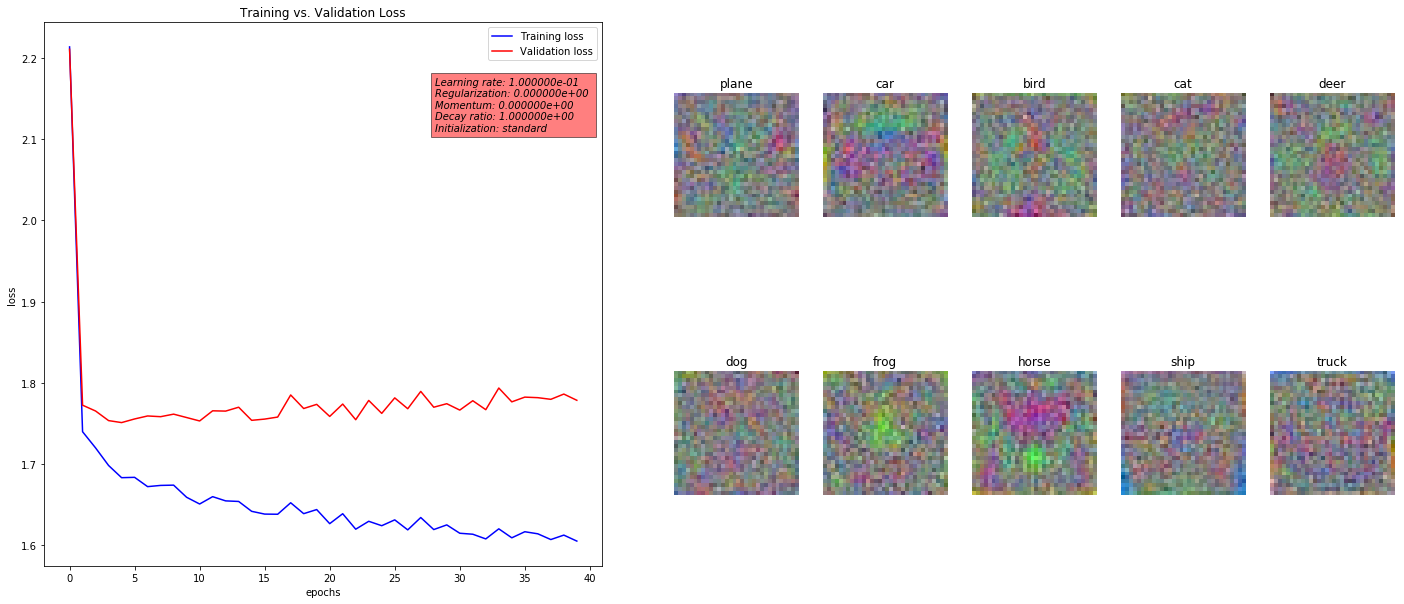

In [12]:
plotNicely()

Final test set accuracy: 0.399000


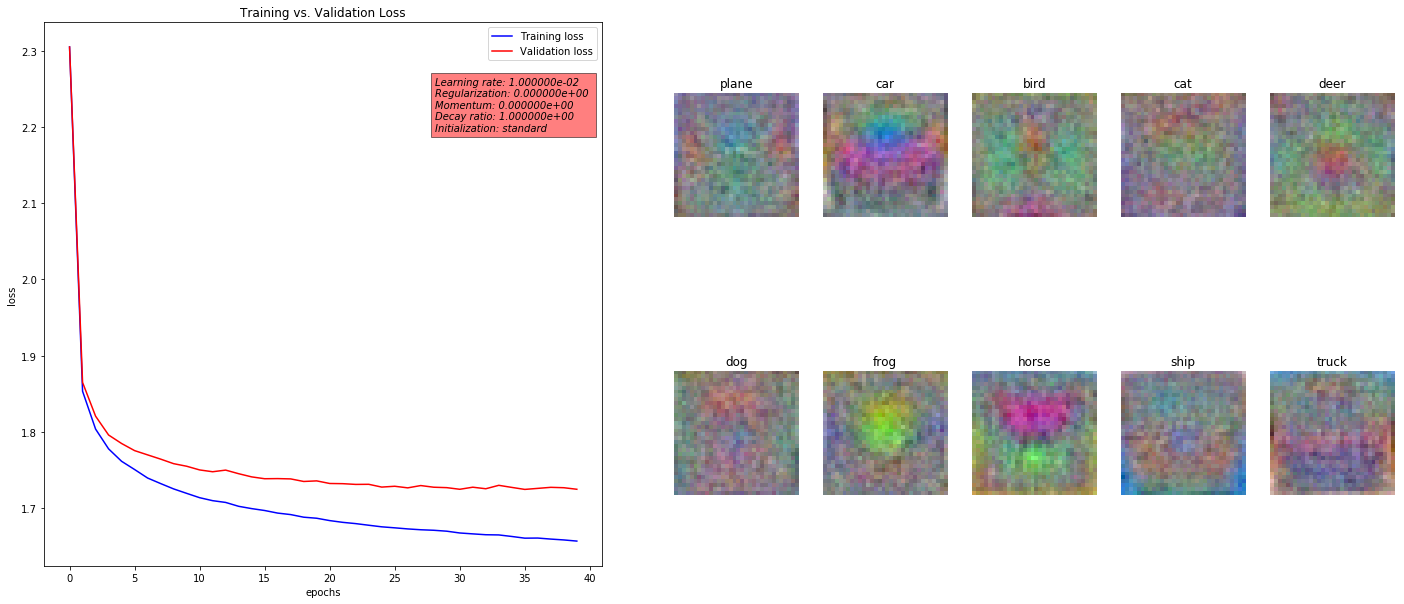

In [10]:
np.random.seed(1)
softmax = Softmax()
lr= 0.01
reg=0.0
momentum = 0.0
decay = 1.0
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)
plotNicely()

Final test set accuracy: 0.366000


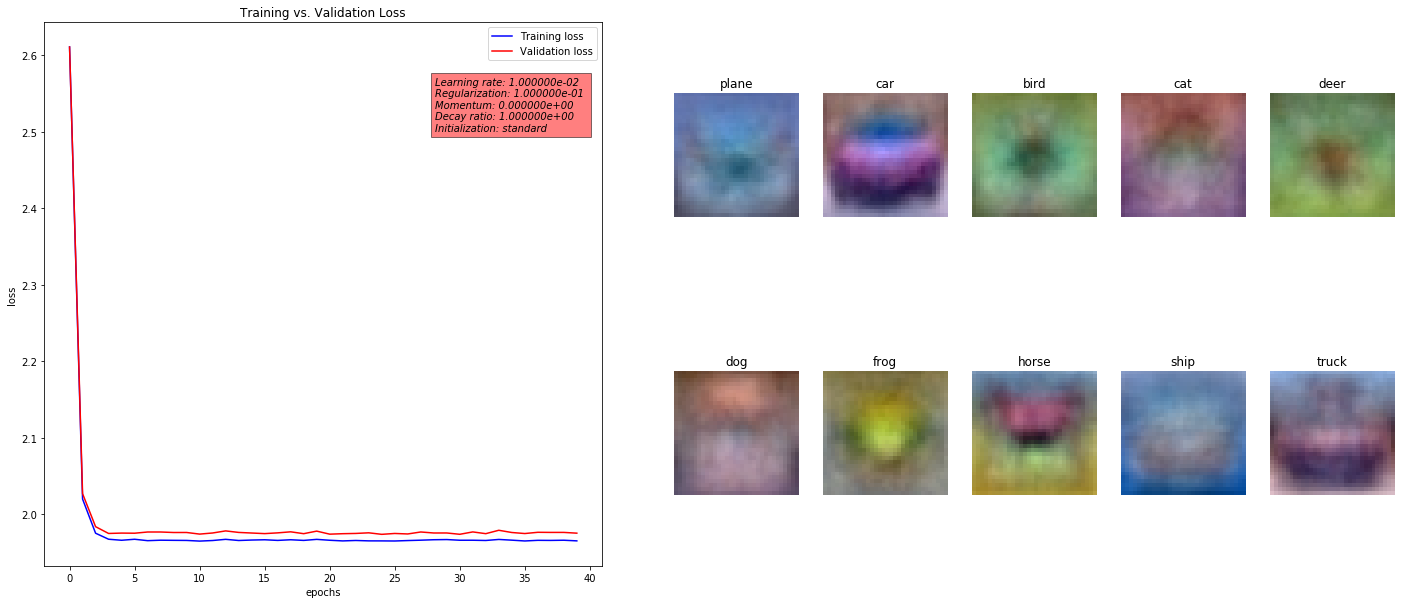

In [11]:
np.random.seed(1)
softmax = Softmax()
lr= 0.01
reg=0.1
momentum = 0.0
decay = 1.0
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)

plotNicely()

Final test set accuracy: 0.314000


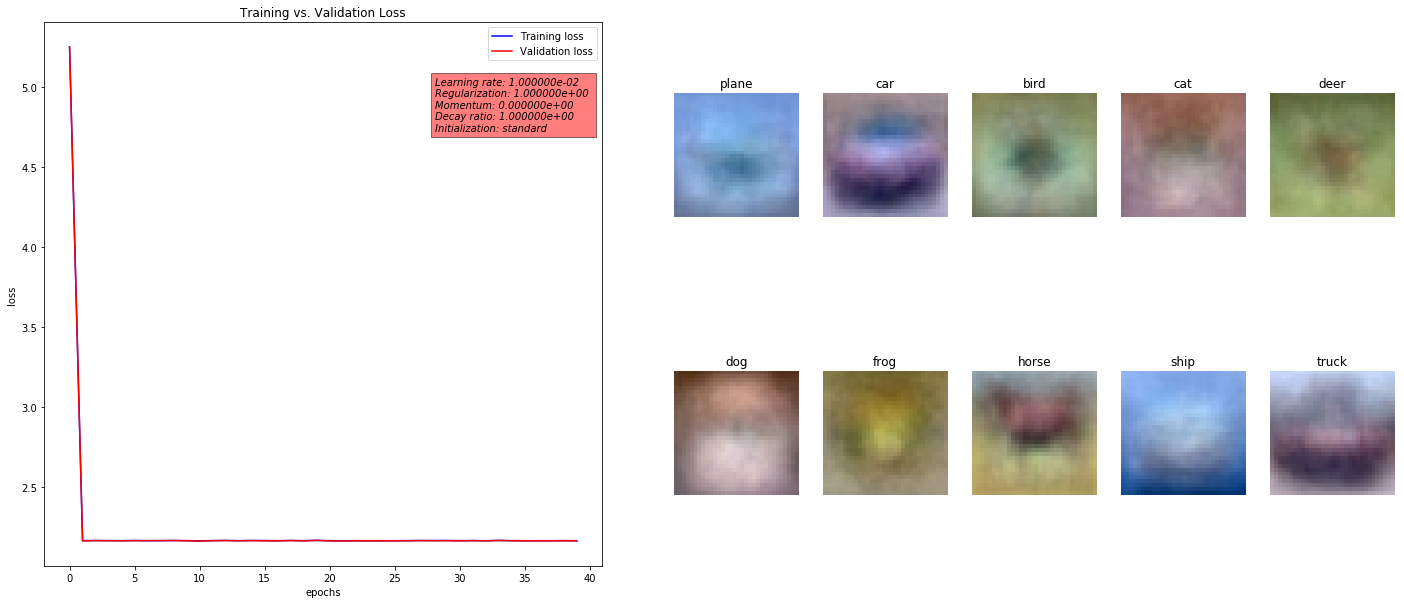

In [12]:
np.random.seed(1)
softmax = Softmax()
lr= 0.01
reg= 1.0
momentum = 0.0
decay = 1.0
init = 'standard'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             momentum=momentum,
                                                             decay=decay,
                                                             initialization=init)

plotNicely()

# Comments about the results
- With a high learning rate, the loss curve becomes *choppy*, maybe the gradient descent is jumping over the ravines.
- Without regularization we might want to use early stopping to avoid overfitting - but then your loss may not be as low so it is better to find a good regularization value.
- Overregularization ends up with an overall worse model. The training and validation loss curves becomes nearly identical, so our model is probably underfitting.
- *Smoother* weight matrices does not seem to relate to better performance. The *smoothest* ones were achieved by the highest regularization case yet those models are not the best performing ones.

# Improvements

Here I have implemented grid search for the hyperparameters. The training also incorporates
- Images have std=1 as well as being zero-mean,
- Xavier initialization, 
- Increased training set size,
- Learning rate decay of 0.9 at each epoch and,
- Nesterov momentum (at 0.9).

After the hyperparameter selection create a bunch of classifiers using different initial weights and then take the average of the results by voting.

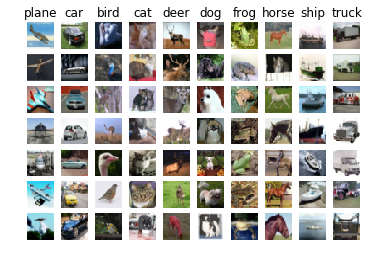

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [13]:
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data(num_training=49000, num_validation=1000, uniform_std=True)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

In [ ]:
np.random.seed(1)
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
#from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

#starting and ending values of the hyperparameters to search (in logspace)
start_reg = 1
end_reg = -7
start_lr = -4
end_lr = -7
#number of hyperparameters to check
nr_of_hyper = 9

learning_rates = np.logspace(start_lr, end_lr, num=nr_of_hyper )
regularization_strengths = np.logspace(start_reg, end_reg, num=nr_of_hyper)
#learning_rates = [1e-7, 5e-7]
#regularization_strengths = [2.5e4, 5e4]


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

zs = []
best_lr = best_reg = []
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                                     X_val, y_val,
                                                                     learning_rate=lr, 
                                                                     reg=reg, 
                                                                     num_iters=4500,
                                                                     decay = 0.9,
                                                                     momentum=0.999,
                                                                     initialization='xavier')
        
        y_train_pred = softmax.predict(X_train)
        training_acc = np.mean(y_train == y_train_pred)
        print('training accuracy for reg %e and lr %e: %f' % (reg, lr, training_acc))
        
        y_val_pred = softmax.predict(X_val)
        validation_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy for reg %e and lr %e: %f' % (reg, lr, validation_acc))
        print('---------------------------------------------------------')
        zs.append(validation_acc)
        results[(lr,reg)] = (training_acc,validation_acc)
        if validation_acc > best_val:
            best_val = validation_acc
            best_softmax = softmax
            best_lr = lr
            best_reg = reg
            best_losses = losses
            best_total_val_losses = total_train_losses
            best_total_train_losses = total_train_losses

#pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
#for lr, reg in sorted(results):
#    train_accuracy, val_accuracy = results[(lr, reg)]
#    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('with reg %e and lr %e' %(best_reg, best_lr))

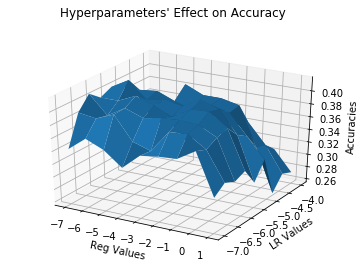

In [17]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
reg_vals = np.linspace(start_reg, end_reg, nr_of_hyper)
lr_vals = np.linspace(start_lr, end_lr, nr_of_hyper)
REGVALS, LRVALS = np.meshgrid(reg_vals, lr_vals)
VALIDATION_ACC = np.asarray(zs).reshape(REGVALS.shape)
ax.plot_surface(REGVALS, LRVALS, VALIDATION_ACC)

ax.set_xlabel('Reg Values')
ax.set_ylabel('LR Values')
ax.set_zlabel('Accuracies')
fig.suptitle('Hyperparameters\' Effect on Accuracy');

In [18]:
np.random.seed(1)
softmax = Softmax()
lr= best_lr
reg= best_reg
momentum = 0.999
decay = 0.9
init = 'xavier'
losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                             X_val, y_val,
                                                             learning_rate=lr, 
                                                             reg=reg, 
                                                             num_iters=18000,
                                                             decay=decay,
                                                             momentum=momentum,
                                                             initialization=init)

Final test set accuracy: 0.400000


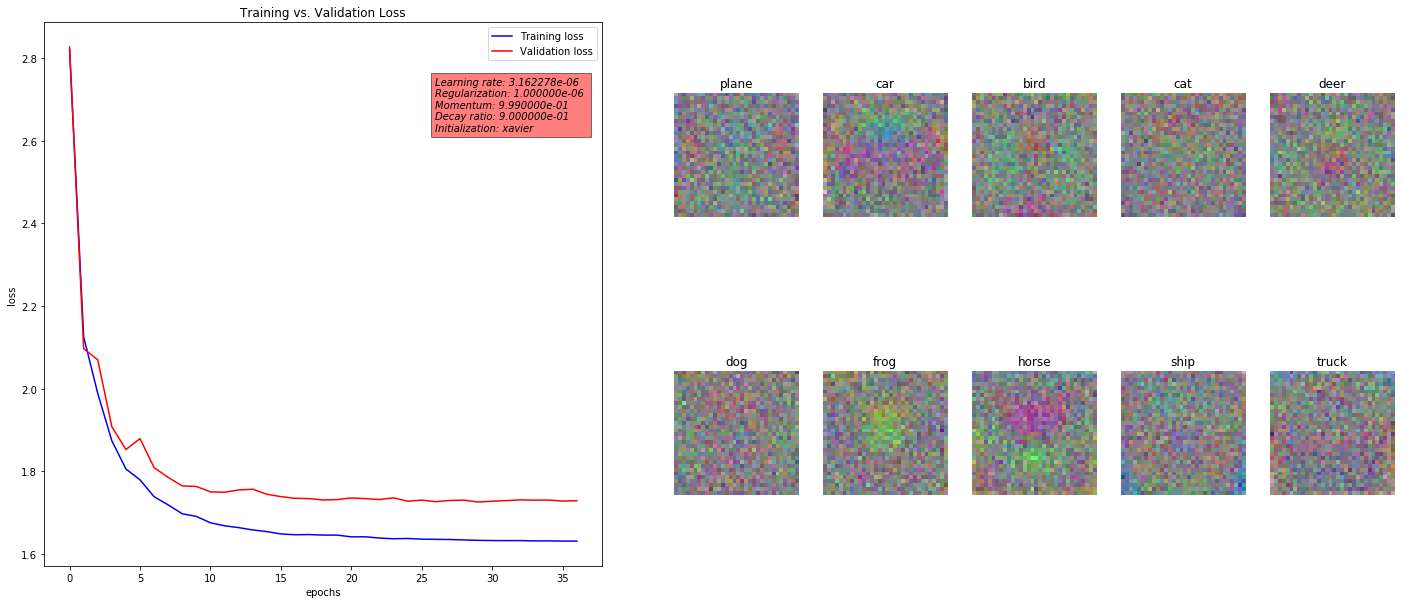

In [19]:
plotNicely()

Create some classifiers and vote on the predictions to create an ensemble. Note that I have increased the regularization parameter a little since it looks like the above model is close to overfitting.

In [31]:
classifiers = []

In [45]:
for i in range(25):
    np.random.seed(i)
    softmax = Softmax()
    lr= best_lr
    reg= best_reg
    momentum = 0.999
    decay = 0.9
    init = 'xavier'
    losses, total_val_losses, total_train_losses = softmax.train(X_train, y_train,
                                                                 X_val, y_val,
                                                                 learning_rate=lr, 
                                                                 reg=reg, 
                                                                 num_iters=18000,
                                                                 decay=decay,
                                                                 momentum=momentum,
                                                                 initialization=init)
    classifiers.append(softmax)                   

In [101]:
y_test_predictions = []
for classifier in classifiers:
    y_test_pred = classifier.predict(X_test)
    y_test_predictions.append(y_test_pred)
    test_accuracy = np.mean(y_test == y_test_pred)
y_test_predictions = np.asarray(y_test_predictions)
pred = np.zeros(1000)
for i in range(1000):
    pred[i] = np.argmax(np.bincount(y_test_predictions[:,i], minlength=10))
test_accuracy = np.mean(y_test == pred)
print('Ensemble test accuracy is %f' %test_accuracy)

Ensemble test accuracy is 0.402000


# Comments about the improvements
- I did not directly guess the grid-search limits. I started with a wider search span initially, plotted the resultant accuracies as shown in the **Hyperparameters' Effect on Accuracy** figure above and then started a new grid-search with narrower limits on learning rate and regularization.
- Momentum helped with the training speed a lot, but in the end I reduced the learning rate so much that the loss plots became similar to the 0 momentum case.
- Decay helped with the *choppiness* of the loss curves.
- Xavier initialization did not create much difference. Probably because this is a single layer network.
- Ensembling also did not yield any benefit, rather it proved that training was more or less robust to the weight initialization.
- Increasing training set size was not significant since I had already used 45000 initially. -
- Making the images' std equal to 1 and mean equal to 0 made a marginal difference but it is simple and fast.